In [1]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer
from transformers import DistilBertForTokenClassification
from transformers import Trainer, TrainingArguments

from sklearn.preprocessing import MinMaxScaler

In [2]:
# split the string column into separate features
def split_string2(text):
    features = text.split(',')
    for i in range(len(features)):
        if i == 0 or i == 1:
            if features[i] != 'nan':
                timestamp = datetime.strptime(features[i], '%Y-%m-%d %H:%M:%S%z')
                features[i] = timestamp.timestamp()
            else:
                features[i] = datetime(2000, 1, 1, 0, 0, 0, tzinfo=None).timestamp()
        else:
            features[i] = float(features[i])
    return features 

In [3]:
from datetime import datetime

# Function to process a single chunk of data
def process_chunk(chunk):
    # Replace "Legit" with 1 and "Dodgy" with 0 in 'Label' column
    chunk['encoded_label'] = chunk['Label'].replace({'Legit': 1, 'Dodgy': 0})
    
    # Get a list of column names to concatenate
    cols_to_concat = [col for col in chunk.columns if col not in ['Label', 'encoded_label']]
    # Concatenate the values in each row of the specified columns, and store the result in a new column called 'concatenated_values'
    chunk['text'] = chunk[cols_to_concat].apply(lambda row: ','.join(str(val) for val in row), axis=1)

    return chunk[['text', 'encoded_label']]

# Read and process the data in chunks
chunksize = 1000000  # Adjust this value based on your available memory
processed_data = []

# If have a saved matching input format validation

In [4]:
# train_processed_data = pd.read_csv('./output/non_nan_balanced_data.csv')
val_processed_data_expanded = pd.read_csv('./output/scaled_val_data.csv') 
# processed_data_expanded = processed_data_expanded.drop('Unnamed: 0', axis=1)

val_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,encoded_tags
0,0.566236,0.697855,0.009106,0.000000e+00,0.000000e+00,0.000000,0.000000,0.009106,0.000000,3.972780e-05,...,0.0,9.179891e-05,2.248993e-02,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184
1,0.395012,0.999643,0.012381,0.000000e+00,9.524506e-04,0.000000,0.000000,0.012382,0.000697,1.076902e-04,...,0.0,4.002599e-05,6.486638e-03,0.730756,0.007162,0.013356,6.395042e-04,0.000000e+00,0.000405,180
2,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
3,0.387087,0.560943,0.115950,3.422385e-09,7.597835e-01,0.928852,0.000010,0.115950,1.000000,3.698501e-06,...,1.0,3.437215e-09,1.528109e-08,0.184108,0.000010,0.197636,1.000000e+00,1.319294e-05,0.000027,154
4,0.481720,0.478761,0.001350,4.569686e-06,1.391312e-02,0.000000,0.000000,0.001350,0.003393,5.133540e-05,...,1.0,1.723015e-06,3.776245e-05,0.094714,0.017997,0.015916,2.773921e-01,0.000000e+00,0.000272,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123244,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
1123245,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
1123246,0.428620,1.000000,0.509812,0.000000e+00,8.906781e-07,0.000000,0.000000,0.509813,0.000001,2.486586e-06,...,0.0,9.179891e-05,2.248993e-02,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184
1123247,0.288678,0.987561,0.033791,2.722036e-03,1.401579e-02,0.000009,0.000208,0.033779,0.001292,4.493264e-05,...,1.0,8.863601e-04,2.160720e-02,0.905640,0.000995,0.066771,1.111779e-01,2.173034e-02,0.000083,75


In [5]:
# # Define the features and the target
# # feature_12 is Tags --> remove
# processed_data_expanded = processed_data_expanded.drop('feature_12', axis=1)

# # Define the desired column names
# new_column_names = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
#                     'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11',
#                     'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
#                     'feature_18', 'feature_19', 'encoded_tags']

# # Rename the columns
# processed_data_expanded.columns = new_column_names

# scale_pos_weight = len(processed_data_expanded[processed_data_expanded['encoded_label'] == 1]) / len(processed_data_expanded[processed_data_expanded['encoded_label'] == 0])
X_val = val_processed_data_expanded.drop('encoded_tags', axis=1)
y_val = val_processed_data_expanded['encoded_tags']

X_val

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,0.566236,0.697855,0.009106,0.000000e+00,0.000000e+00,0.000000,0.000000,0.009106,0.000000,3.972780e-05,0.171641,0.0,9.179891e-05,2.248993e-02,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003
1,0.395012,0.999643,0.012381,0.000000e+00,9.524506e-04,0.000000,0.000000,0.012382,0.000697,1.076902e-04,0.632633,0.0,4.002599e-05,6.486638e-03,0.730756,0.007162,0.013356,6.395042e-04,0.000000e+00,0.000405
2,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,0.376586,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000
3,0.387087,0.560943,0.115950,3.422385e-09,7.597835e-01,0.928852,0.000010,0.115950,1.000000,3.698501e-06,0.203465,1.0,3.437215e-09,1.528109e-08,0.184108,0.000010,0.197636,1.000000e+00,1.319294e-05,0.000027
4,0.481720,0.478761,0.001350,4.569686e-06,1.391312e-02,0.000000,0.000000,0.001350,0.003393,5.133540e-05,0.032889,1.0,1.723015e-06,3.776245e-05,0.094714,0.017997,0.015916,2.773921e-01,0.000000e+00,0.000272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123244,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,0.376586,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000
1123245,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,0.376586,0.0,1.587743e-08,3.891505e-06,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000
1123246,0.428620,1.000000,0.509812,0.000000e+00,8.906781e-07,0.000000,0.000000,0.509813,0.000001,2.486586e-06,0.601457,0.0,9.179891e-05,2.248993e-02,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003
1123247,0.288678,0.987561,0.033791,2.722036e-03,1.401579e-02,0.000009,0.000208,0.033779,0.001292,4.493264e-05,0.720373,1.0,8.863601e-04,2.160720e-02,0.905640,0.000995,0.066771,1.111779e-01,2.173034e-02,0.000083


In [6]:
# Remove the Tag class with below 10 count, double check to make sure
counts = y_val.value_counts()

y_val = y_val[y_val.isin(counts[counts > 10].index)] # 10 is cutof as mentioned in Preprocessing step
X_val = X_val.loc[y_val.index]

# XGBoost

Since XGBoost can manually use adjust the scale of minority class, using non-oversampling/undersampling data is beneficial because it avoids duplicate data

In [7]:
train_processed_data_expanded = pd.read_csv('./output/scaled_train_data.csv')
# train_processed_data_expanded = train_processed_data_expanded.drop('Unnamed: 0', axis=1)

train_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,encoded_tags
0,0.428620,1.000000,0.509812,0.000000e+00,8.906781e-07,0.000000,0.000000,0.509813,0.000001,2.486586e-06,...,0.0,9.179891e-05,0.022490,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184
1,0.578240,0.999839,0.016088,6.101171e-03,3.595742e-01,0.000223,0.000125,0.016082,0.037998,6.038352e-05,...,1.0,5.081934e-03,0.039148,0.764455,0.000006,0.019570,2.624302e-01,0.000000e+00,0.000404,141
2,0.467841,0.996626,0.002890,0.000000e+00,0.000000e+00,0.000000,0.000000,0.002891,0.000000,4.092086e-04,...,0.0,1.040388e-04,0.028460,0.859879,0.242375,0.361443,3.157241e-02,6.552889e-06,0.000009,194
3,0.322503,0.989857,0.023677,1.015950e-06,7.954423e-01,0.412684,0.127934,0.015942,0.116336,6.150468e-05,...,0.0,2.787286e-04,0.033901,0.751330,0.049434,0.032961,4.568948e-02,1.137700e-03,0.000133,60
4,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,0.000004,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5388330,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,0.000004,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
5388331,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,0.000004,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
5388332,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.000000,1.000000,0.052762,7.937312e-07,...,0.0,1.587743e-08,0.000004,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
5388333,0.293524,0.951149,0.006017,0.000000e+00,4.639506e-07,0.000000,0.000000,0.006017,0.000001,2.380474e-04,...,0.0,8.850077e-05,0.009008,0.996098,0.070973,0.048470,1.586959e-01,6.269141e-01,0.000092,142


In [8]:
test_processed_data_expanded = pd.read_csv('./output/scaled_test_data.csv')
# train_processed_data_expanded = train_processed_data_expanded.drop('Unnamed: 0', axis=1)

test_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,encoded_tags
0,0.327324,0.999999,0.219593,1.000000e+00,4.189355e-01,0.000000,0.00000,0.219594,5.066213e-02,6.685087e-06,...,0.0,1.000000e+00,1.000000,0.998936,0.001565,0.153770,5.788697e-01,8.198362e-01,0.000041,124
1,0.327324,0.999999,0.219593,1.000000e+00,4.189355e-01,0.000000,0.00000,0.219594,5.066213e-02,6.685087e-06,...,0.0,1.000000e+00,1.000000,0.998936,0.001565,0.153770,5.788697e-01,8.198362e-01,0.000041,124
2,0.268661,0.999726,0.011852,0.000000e+00,4.806285e-08,0.000000,0.00000,0.011853,1.266585e-07,1.335921e-04,...,0.0,1.040388e-04,0.028460,0.859879,0.242375,0.361443,3.157241e-02,6.552889e-06,0.000009,194
3,0.428620,1.000000,0.509812,0.000000e+00,8.906781e-07,0.000000,0.00000,0.509813,1.013268e-06,2.486586e-06,...,0.0,9.179891e-05,0.022490,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184
4,0.387329,0.612336,0.001213,0.000000e+00,0.000000e+00,0.000000,0.00000,0.001214,0.000000e+00,4.416578e-04,...,0.0,1.099598e-05,0.008395,0.300106,0.000536,0.002547,0.000000e+00,4.597327e-07,0.002466,214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149097,0.296351,0.983435,0.160314,4.718805e-03,4.475495e-02,0.000000,0.00000,0.160314,1.199722e-03,9.322364e-06,...,1.0,4.734385e-03,0.001017,0.706279,0.000131,0.130509,3.088446e-02,4.192803e-07,0.000040,106
1149098,0.668298,1.000000,1.000000,6.884876e-09,1.000000e+00,0.000000,0.00000,1.000000,5.276211e-02,7.937312e-07,...,0.0,1.587743e-08,0.000004,0.580702,0.000543,1.000000,8.483211e-01,1.026006e-03,0.000000,203
1149099,0.387087,0.560943,0.115950,3.422385e-09,7.597835e-01,0.928852,0.00001,0.115950,1.000000e+00,3.698501e-06,...,1.0,2.448698e-08,0.000063,0.208585,0.000009,0.176432,8.838643e-01,1.165525e-05,0.000031,99
1149100,0.428620,1.000000,0.509812,0.000000e+00,8.906781e-07,0.000000,0.00000,0.509813,1.013268e-06,2.486586e-06,...,0.0,9.179891e-05,0.022490,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184


In [9]:
# Define the features and the target
# scale_pos_weight = len(processed_data_expanded[processed_data_expanded['encoded_label'] == 1]) / len(processed_data_expanded[processed_data_expanded['encoded_label'] == 0])
X_train = train_processed_data_expanded.drop('encoded_tags', axis=1)
y_train = train_processed_data_expanded['encoded_tags']

X_test = test_processed_data_expanded.drop('encoded_tags', axis=1)
y_test = test_processed_data_expanded['encoded_tags']

In [10]:
# # Calculate the scale_pos_weight if you haven't done it yet
# scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
# scale_pos_weight

import xgboost as xgb

# Compute class weights
class_weights = y_train.value_counts().min() / y_train.value_counts()

# Convert the dataset into DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set weight
weights = y_train.map(class_weights)
dtrain.set_weight(weights)

In [21]:
# import xgboost as xgb

# clf = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight) # 0.99 means a more balanced dataset than scale_pos_weight
# clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [22]:
# clf.save_model("./temp/xgb_model.bin") # _099

# Training

In [23]:
# from sklearn.preprocessing import LabelEncoder
# from xgboost import XGBClassifier
# from sklearn.metrics import log_loss

# # Define a LabelEncoder
# train_le = LabelEncoder()
# test_le = LabelEncoder()
# val_le = LabelEncoder()

# # Fit the LabelEncoder and transform y_train, y_val and y_test due to the fact we removed classes, making invalid for ML
# y_train_encoded = train_le.fit_transform(y_train)
# y_test_encoded = test_le.fit_transform(y_test)
# y_val_encoded = val_le.fit_transform(y_test)

In [21]:
# Define parameters of the model
params = {
    'objective': 'multi:softprob',  # for multiclass classification
    'num_class': len(np.unique(y_train)),  # number of classes
    'eval_metric': 'mlogloss'  # evaluation metric for multiclass
}

# Watch list to see the evaluation metric on both training and test set
watchlist = [(dtrain, 'train'), (dtest, 'test')]

# Training the model
# Note: train time over 30 min for 3 rounds, 58 mins for 5 rounds
# Note: 3 round seems to be fine for this data set, 81% precision, 86% recall and 93% ROC AUC
# Note: 5 round: 98% precision, 99% recall and 99% ROC AUC
bst = xgb.train(params, dtrain, num_boost_round=3, evals=watchlist, verbose_eval=True)

[0]	train-mlogloss:4.49706	test-mlogloss:4.56096
[1]	train-mlogloss:3.61334	test-mlogloss:3.75027
[2]	train-mlogloss:2.73083	test-mlogloss:2.94086
[3]	train-mlogloss:1.89108	test-mlogloss:2.15501
[4]	train-mlogloss:1.32717	test-mlogloss:1.48596


In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# get the class with the highest probability for each instance
# Predict the class probabilities on the test set
y_pred_prob = bst.predict(dtest)
y_pred_max_prob = np.argmax(y_pred_prob, axis=1)

y_pred_max_prob

array([124, 124, 194, ...,  99, 184, 184], dtype=int64)

In [23]:
# Print classification report
print(classification_report(y_test, y_pred_max_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3486
           1       1.00      1.00      1.00      4293
           2       1.00      1.00      1.00      2190
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00       281
           5       1.00      1.00      1.00      1265
           6       1.00      1.00      1.00       381
           7       1.00      1.00      1.00      4526
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00      3493
          10       0.53      1.00      0.69        31
          11       1.00      0.99      0.99      2601
          12       1.00      0.96      0.98        94
          13       1.00      1.00      1.00        26
          14       1.00      1.00      1.00      4877
          15       1.00      1.00      1.00       743
          16       1.00      1.00      1.00       348
          17       1.00    

In [24]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve

# Binarize the output
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_test_pred_bin = lb.transform(y_pred_max_prob)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test_bin, y_test_pred_bin, average='macro')
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.9965006255503546


In [27]:
bst.save_model("./output/xgb_model_3r.bin")

# Validation Data

In [ ]:
import xgboost as xgb

bst = xgb.Booster()
bst.load_model("./output/xgb_model_3r.bin") # _099

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

dval = xgb.DMatrix(X_val, label=y_val)

# Predict the class probabilities on the test set
y_pred_prob = bst.predict(dval)

# get the class with the highest probability for each instance
y_pred_max_prob = np.argmax(y_pred_prob, axis=1)

# Print classification report
# Note: 3 round: 79 precision, 83 recall, 93 ROC AUC
# Note: 5 round: 97 precision, 98 recall, 99 ROC AUC
print(classification_report(y_val, y_pred_max_prob))

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3407
           1       1.00      1.00      1.00      4197
           2       1.00      1.00      1.00      2141
           4       1.00      1.00      1.00       275
           5       1.00      1.00      1.00      1237
           6       1.00      1.00      1.00       372
           7       1.00      1.00      1.00      4424
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00      3414
          10       0.56      1.00      0.71        30
          11       1.00      0.99      0.99      2543
          12       1.00      0.93      0.97        92
          13       1.00      1.00      1.00        26
          14       1.00      1.00      1.00      4768
          15       1.00      1.00      1.00       727
          16       1.00      1.00      1.00       340
          17       1.00      1.00      1.00       278
          18       1.00    

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve

# Binarize the output
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_val)
y_test_pred_bin = lb.transform(y_pred_max_prob)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test_bin, y_test_pred_bin, average='macro')
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.9973129266033116


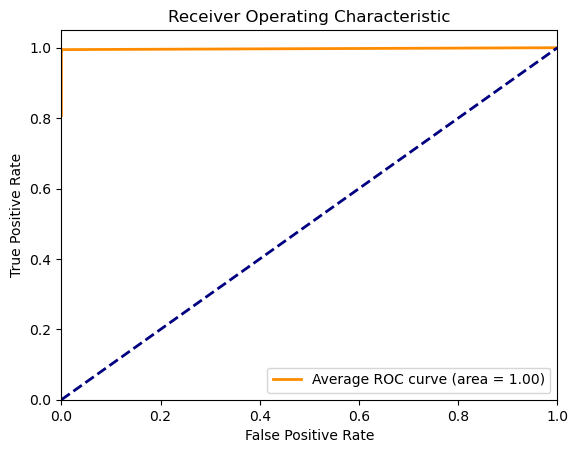

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute ROC curve and ROC area for each class
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot average ROC curve
plt.figure()
plt.plot(fpr["macro"], tpr["macro"], color='darkorange', lw=2, label='Average ROC curve (area = %0.2f)' % roc_auc["macro"])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('./output/xgb_5r.png')
plt.show()

In [12]:
# from sklearn.metrics import average_precision_score

# # XGBoost
# xgb_auprc = average_precision_score(y_val, y_val_pred_max_prob)
# print(f'XGBoost AUPRC: {xgb_auprc}')

XGBoost AUPRC: 0.9996413502662841


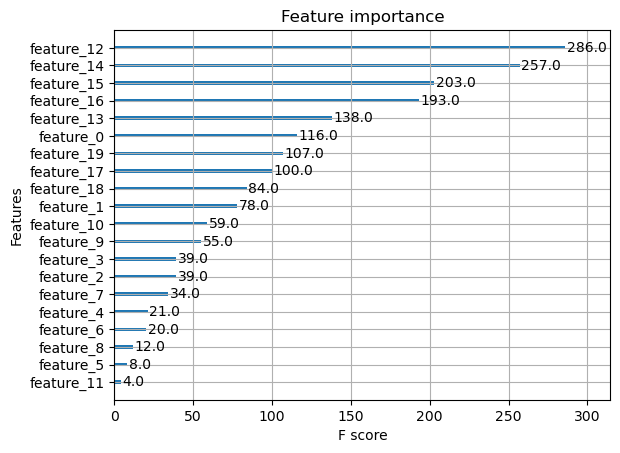

In [28]:
import matplotlib.pyplot as plt

# assuming that bst is your trained model
# e.g. bst = xgb.train(params, dtrain, num_rounds)
xgb.plot_importance(bst)
plt.show()

FScore

f12: 286 MeanNumTransactions --> tag cluster

f14 : 257 StdDevBalance --> tag cluster

f15: 203 ClusterLifetime --> tag cluster

f16: 193 NumWithdrawalsPerMonth --> tag cluster

f13: 138 MeanBalance --> tag cluster